# Test (classification supervised learning)

In [53]:
%matplotlib inline

In [54]:
%run setup_environment.py
%run custom_tools.py
%run ml_tools.py

current_conda_env = !echo $CONDA_DEFAULT_ENV
check_conda_env(current_conda_env[0])

Setup environment... done!


✅ <span style='color:green'>Working on **impact-annotator_env** conda environment.</span>

In [55]:
impact = pd.read_csv('../../data/annotated_final_IMPACT_mutations_180508.txt', sep = '\t', low_memory = False, nrows = 10000)
impact.shape

(10000, 63)

## Feature processsing

### `is_somatic`

In [56]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,9649,96.5%
UNLIKELY,281,2.8%
MANUAL_OK,70,0.7%


In [57]:
impact['is_somatic'] = impact.confidence_class == "UNLIKELY"
get_table(impact.is_somatic)

,count_,freq_
False,9719,97.2%
True,281,2.8%


### `is_driver`

In [58]:
get_table(impact.oncogenic)

,count_,freq_
Unknown,6350,63.5%
Likely Oncogenic,2689,26.9%
Oncogenic,764,7.6%
Predicted Oncogenic,162,1.6%
Likely Neutral,19,0.2%
Inconclusive,16,0.2%


In [59]:
impact['is_driver'] = impact.oncogenic.isin(['Likely Oncogenic', 'Oncogenic', 'Predicted Oncogenic'])
get_table(impact.is_driver)

,count_,freq_
False,6385,63.8%
True,3615,36.2%


## Setup the train/test sets

In [60]:
label_feature_name = 'is_driver'

feature_names = [
# 'Hugo_Symbol', 'Chromosome', 'Start_Position', 'End_Position', 'Consequence', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele2', 'Tumor_Sample_Barcode',
# 'cDNA_change', 'HGVSp_Short',
't_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count',
# 't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
#'confidence_class',
'sample_coverage',
#'mut_key',
#'VAG_VT', 'VAG_GENE', 'VAG_cDNA_CHANGE', 'VAG_PROTEIN_CHANGE', 'VAG_EFFECT',
'VEP_Consequence',
#'VEP_SYMBOL', 'VEP_HGVSc', 'VEP_HGVSp',
'VEP_Amino_acids',
'VEP_VARIANT_CLASS',
#'VEP_EXON', 'VEP_INTRON',
'VEP_IMPACT',
'VEP_CLIN_SIG',
'VEP_COSMIC_CNT',
'VEP_gnomAD_AF',
# 'sample_mut_key', 'patient_key',
'frequency_in_normals',
'VEP_SIFT_class',
'VEP_SIFT_score',
'VEP_PolyPhen_class',
'VEP_PolyPhen_score',
'VEP_in_dbSNP',
'VEP_gnomAD_total_AF_AFR',
'VEP_gnomAD_total_AF_AMR',
'VEP_gnomAD_total_AF_ASJ',
'VEP_gnomAD_total_AF_EAS',
'VEP_gnomAD_total_AF_FIN',
'VEP_gnomAD_total_AF_NFE',
'VEP_gnomAD_total_AF_OTH',
'VEP_gnomAD_total_AF_max',
'VEP_gnomAD_total_AF',
'Kaviar_AF',
# 'is_a_hotspot',
# 'is_a_3d_hotspot',
# 'oncogenic',
'gene_type',
label_feature_name
]

categorical_features_names = [
'VEP_Consequence',
'VEP_Amino_acids',
'VEP_VARIANT_CLASS',
'VEP_IMPACT',
'VEP_CLIN_SIG',
'VEP_SIFT_class',
'VEP_PolyPhen_class',
'VEP_in_dbSNP',
'gene_type',
]

In [61]:
impact_sel = impact[feature_names].dropna()

In [62]:
impact_sel = pd.get_dummies(impact_sel, columns = categorical_features_names, sparse = True)

In [63]:
# shuffle data
rng = np.random.RandomState(0)
permutation = rng.permutation(len(impact_sel))
impact_sel = impact_sel.iloc[permutation]

In [64]:
X = impact_sel.drop(label_feature_name, axis = 1) # features matrix X: [n_samples, n_features]
y = impact_sel[label_feature_name]                # target array y: n_samples
print(X.shape)
print(y.shape)

(7267, 214)
(7267,)


In [65]:
get_table(y)

,count_,freq_
False,5729,78.8%
True,1538,21.2%


In [66]:
n_folds = 5

## Dummy

**Uniform** Accuracy: 0.50 ± 0.01 | AUC: 0.50 ± 0.00

**Most Frequent** Accuracy: 0.79 ± 0.00 | AUC: 0.50 ± 0.00

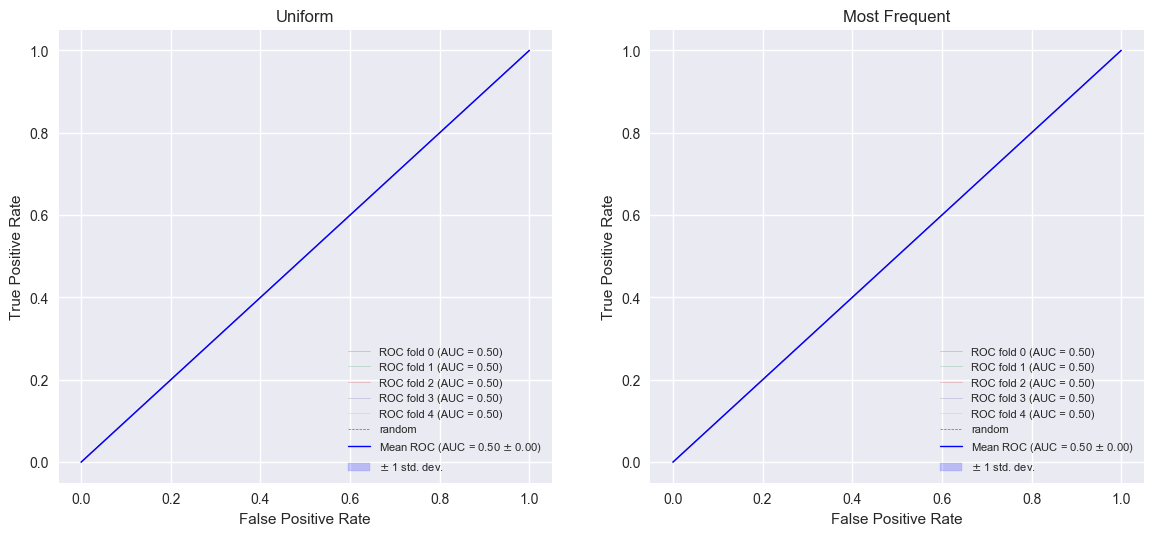

In [67]:
from sklearn.dummy import DummyClassifier

model_uniform = DummyClassifier(strategy = 'uniform', random_state = 1)
model_most_frequent = DummyClassifier(strategy = 'most_frequent', random_state = 1)

get_accuracy_and_AUC(model_uniform, X, y, n_folds, 'Uniform')
get_accuracy_and_AUC(model_most_frequent, X, y, n_folds, 'Most Frequent')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
plot_cross_validation_ROC_curves(model_uniform, X, y, n_folds, 'Uniform', ax1);
plot_cross_validation_ROC_curves(model_most_frequent, X, y, n_folds, 'Most Frequent', ax2);

## Gaussian Naive Bayes

**Gaussian Naive Bayes** Accuracy: 0.82 ± 0.01 | AUC: 0.93 ± 0.01

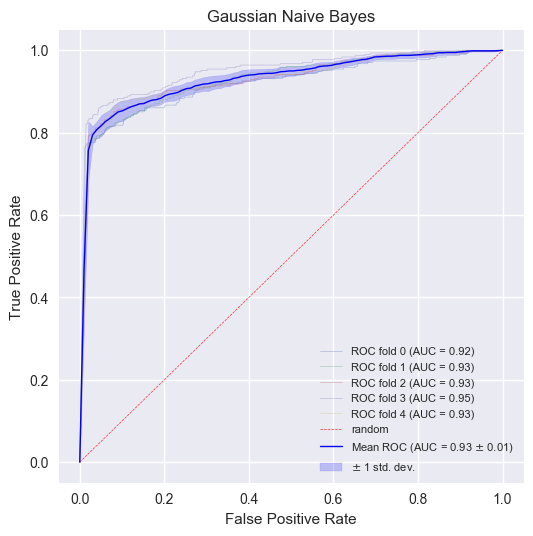

In [68]:
from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB()

get_accuracy_and_AUC(model_GaussianNB, X, y, n_folds, 'Gaussian Naive Bayes')

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_cross_validation_ROC_curves(model_GaussianNB, X, y, n_folds, 'Gaussian Naive Bayes', ax)

## Logistic Regression

**Logistic Regression** Accuracy: 0.96 ± 0.00 | AUC: 0.97 ± 0.01

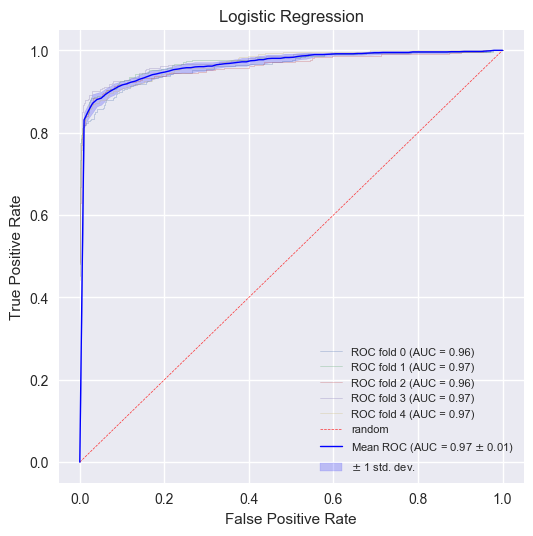

In [69]:
from sklearn.linear_model import LogisticRegression

model_LogisticRegression = LogisticRegression(random_state = 1)

get_accuracy_and_AUC(model_LogisticRegression, X, y, n_folds, 'Logistic Regression')

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_cross_validation_ROC_curves(model_LogisticRegression, X, y, n_folds, 'Logistic Regression', ax)

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = np.linspace(0.1, 1.0, 5), cv = 5)

for i in range(n_folds):
    plt.plot(train_sizes, train_scores[i], linewidth = 0.5, alpha = 0.4, color = 'r',
                     label = 'training score fold %d' % i)
    plt.plot(train_sizes, test_scores[i], linewidth = 0.5, alpha = 0.4, color = 'g',
                     label = 'test score fold %d' % i)
    
train_scores_mean = np.mean(train_scores, axis = 0)
train_scores_std = np.std(train_scores, axis = 0)
test_scores_mean = np.mean(test_scores, axis = 0)
test_scores_std = np.std(test_scores, axis = 0)

plt.plot(train_sizes, train_scores_mean, 'o-r', linewidth = 1,
        label = 'mean training score')
plt.plot(train_sizes, test_scores_mean, 'o-g', linewidth = 1,
         label = 'mean test score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')


plt.xlabel("Training size")
plt.ylabel("Accuracy score")
plt.legend(loc = "lower right", prop = {'size': 5})

## K Nearest Neighbors

**K Nearest Neighbors** Accuracy: 0.89 ± 0.00 | AUC: 0.81 ± 0.01

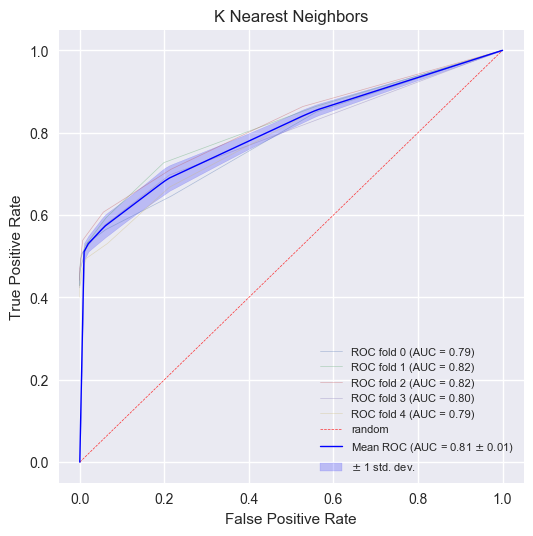

In [70]:
from sklearn.neighbors import KNeighborsClassifier

model_KNeighborsClassifier = KNeighborsClassifier(n_neighbors = 10)

get_accuracy_and_AUC(model_KNeighborsClassifier, X, y, n_folds, 'K Nearest Neighbors')

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_cross_validation_ROC_curves(model_KNeighborsClassifier, X, y, n_folds, 'K Nearest Neighbors', ax);

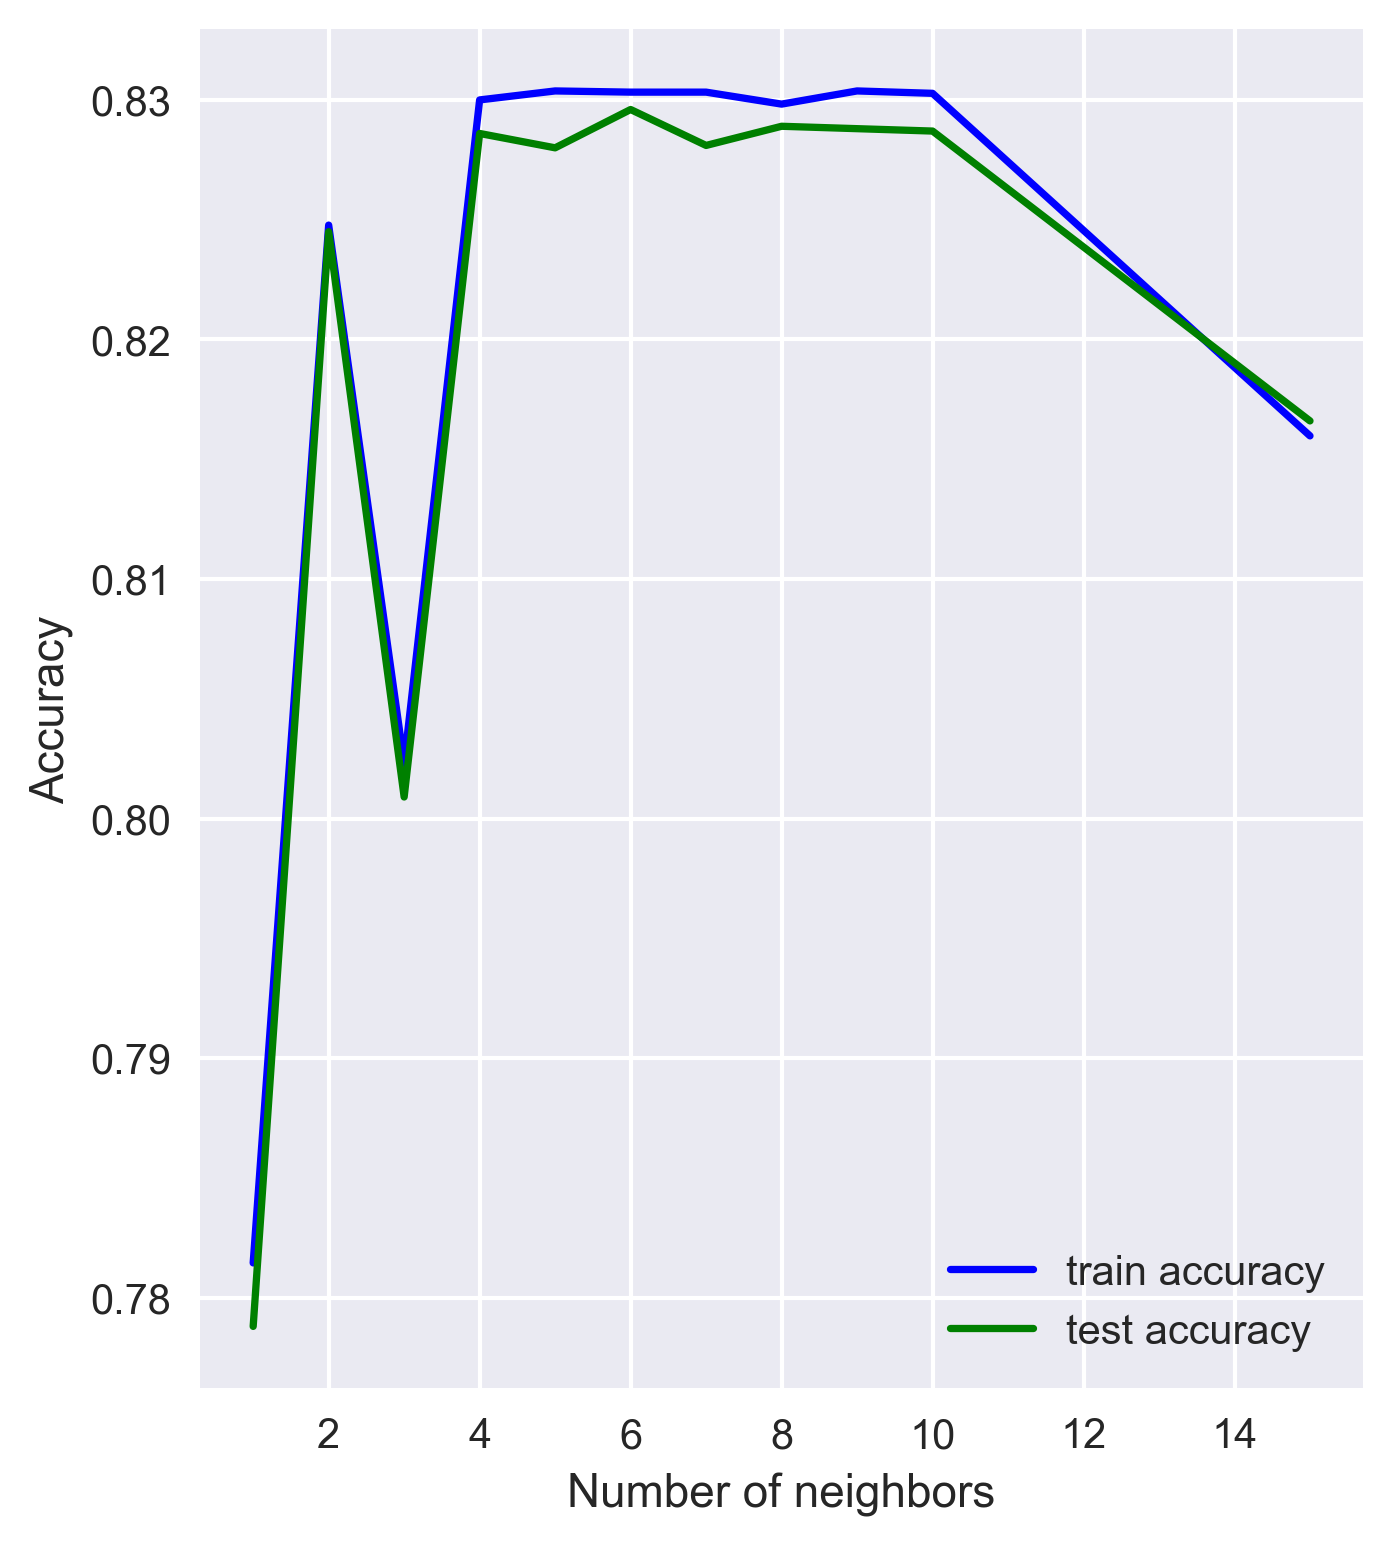

In [110]:
from sklearn.model_selection import validation_curve
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
train_scores, test_scores = validation_curve(KNeighborsClassifier(), X, y, param_name = "n_neighbors", param_range = n_neighbors, cv = n_folds)

plt.figure(figsize = (5, 6))
plt.plot(n_neighbors, train_scores.mean(axis = 1), 'b', label = "train accuracy")
plt.plot(n_neighbors, test_scores.mean(axis = 1), 'g', label = "test accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Number of neighbors')
#plt.xlim([50, 0])
plt.legend(loc = "best");

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_RandomForestClassifier = RandomForestClassifier(n_estimators = 200)

get_accuracy_and_AUC(model_RandomForestClassifier, X, y, n_folds, 'Random Forest')

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_cross_validation_ROC_curves(model_RandomForestClassifier, X, y, n_folds, 'Random Forest', ax);

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC

model = SVC(kernel = 'linear', C = 1E10)

accuracy_scores = cross_val_score(model, X, y, cv = 5)
auc_scores = cross_val_score(model, X, y, cv = n_folds, scoring = "roc_auc")
print("Accuracy: %0.2f ± %0.2f | AUC: %0.2f ± %0.2f" % (accuracy_scores.mean(), accuracy_scores.std(), auc_scores.mean(), auc_scores.std()))
plot1 = plot_cross_validation_ROC_curves(model, X, y, n_folds);